In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# read the given data
data = pd.read_csv('DJI2.csv', index_col=0, parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,12459.540039,12580.349609,12404.820313,12474.519531,12474.519531,327200000
2007-01-04,12473.160156,12510.410156,12403.860352,12480.690430,12480.690430,259060000
2007-01-05,12480.049805,12480.129883,12365.410156,12398.009766,12398.009766,235220000
2007-01-08,12392.009766,12445.919922,12337.370117,12423.490234,12423.490234,223500000
2007-01-09,12424.769531,12466.429688,12369.169922,12416.599609,12416.599609,225190000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3328 entries, 2007-01-03 to 2020-03-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3328 non-null   float64
 1   High       3328 non-null   float64
 2   Low        3328 non-null   float64
 3   Close      3328 non-null   float64
 4   Adj Close  3328 non-null   float64
 5   Volume     3328 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 182.0 KB


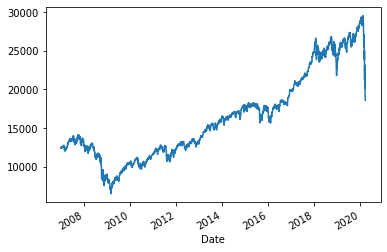

In [4]:
data['Adj Close'].plot()

In [5]:
# see if 'Adj Close' is the same as 'Close'
# if yes drop 'Adj Close'
test = data['Adj Close'] == data['Close']
if all(data['Adj Close'] == data['Close']):
    data = data.drop(columns='Adj Close')



In [6]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-03,12459.540039,12580.349609,12404.820313,12474.519531,327200000
2007-01-04,12473.160156,12510.410156,12403.860352,12480.690430,259060000
2007-01-05,12480.049805,12480.129883,12365.410156,12398.009766,235220000
2007-01-08,12392.009766,12445.919922,12337.370117,12423.490234,223500000
2007-01-09,12424.769531,12466.429688,12369.169922,12416.599609,225190000


In [7]:
data.columns
data.shape

(3328, 5)

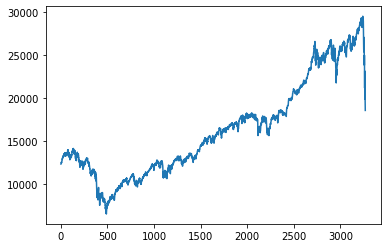

In [8]:
# make data and target arrays
target_style = 'Price' # / 'Price' / 'Change' / 'ChangeP'
window_len = 60
y = np.zeros(data.shape[0]-window_len)
X = np.zeros((data.shape[0]-window_len,window_len,data.shape[1]))
for i in range(data.shape[0]-window_len):
    if target_style == 'Change':
        # target of Change for next day
        y[i] = data['Close'][i+window_len] - data['Close'][i+window_len-1]
    elif target_style == 'ChangeP':
        # target of Change for next day in percentage
        y[i] = (data['Close'][i+window_len] - data['Close'][i+window_len-1]) / data['Close'][i+window_len-1]
    else:
        # target of Price for next day
        y[i] = data['Close'][i+window_len]
        
    X[i,:,:] = data.iloc[i:i+window_len].values
    

plt.plot(y)
plt.show()

In [9]:
X[-1,-10:,:]
y[-1]

18591.929688

In [10]:
# train test split
y_train = y[:int(0.7*len(y))]
y_valid = y[int(0.7*len(y)):int(0.85*len(y))]
y_test = y[int(0.85*len(y)):]
X_train = X[:int(0.7*len(X)),:,:]
X_valid = X[int(0.7*len(X)):int(0.85*len(X)),:,:]
X_test = X[int(0.85*len(X)):,:,:]

In [11]:
# get the max
maxPrice = np.max(X_train[:,:,:-1])
print('max Price: ',maxPrice)
minPrice = np.min(X_train[:,:,:-1])
print('min Price: ',minPrice)
maxVolume = np.max(X_train[:,:,-1])
print('max Volume: ',maxVolume)
minVolume = np.min(X_train[:,:,-1])
print('min Volume: ',minVolume)


max Price:  18351.359375
min Price:  6469.950195
max Volume:  674920000.0
min Volume:  8410000.0


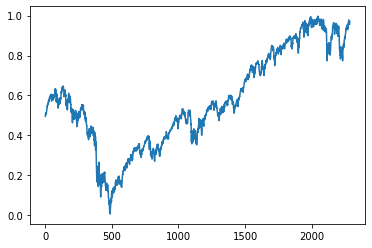

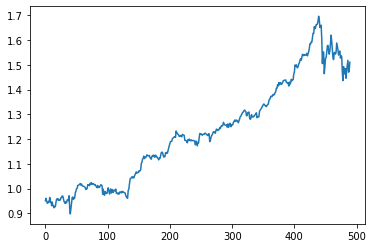

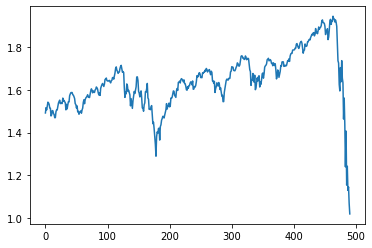

In [12]:
# data scaling
X_train[:,:,:-1] = (X_train[:,:,:-1] - minPrice) / (maxPrice - minPrice)
X_train[:,:,-1] = (X_train[:,:,-1] - minVolume) / (maxVolume - minVolume)

X_valid[:,:,:-1] = (X_valid[:,:,:-1] - minPrice) / (maxPrice - minPrice)
X_valid[:,:,-1] = (X_valid[:,:,-1] - minVolume) / (maxVolume - minVolume)

X_test[:,:,:-1] = (X_test[:,:,:-1] - minPrice) / (maxPrice - minPrice)
X_test[:,:,-1] = (X_test[:,:,-1] - minVolume) / (maxVolume - minVolume)

if target_style == 'Price':
    y_train = (y_train - minPrice) / (maxPrice - minPrice)
    plt.plot(y_train)
    plt.show()
    y_valid = (y_valid - minPrice) / (maxPrice - minPrice)
    plt.plot(y_valid)
    plt.show()
    y_test = (y_test - minPrice) / (maxPrice - minPrice)
    plt.plot(y_test)
    plt.show()
elif target_style == 'Change':
    maxChange = np.max(np.abs(y_train))
    y_train = y_train / maxChange
    plt.plot(y_train)
    plt.show()
    y_valid = y_valid / maxChange
    plt.plot(y_valid)
    plt.show()
    y_test = y_test / maxChange
    plt.plot(y_test)
    plt.show()

In [13]:

from keras.models import Sequential
import keras.layers as layers
from keras.layers import Input, Dense, Dropout, LSTM, CuDNNLSTM, GRU, CuDNNGRU, Bidirectional
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.losses import mean_squared_error
from keras.models import load_model
from keras import backend as K
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [14]:

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))


In [15]:

# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer 
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(units=1))


In [16]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    SS_reg = K.sum(K.square(y_pred - K.mean(y_true)))
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )
    return ( SS_res/(SS_tot + K.epsilon()) )
#     return ( SS_reg/(SS_tot + K.epsilon()) )

In [17]:
# regressor = regressorLSTM
regressor = regressorGRU
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
regressor.compile(optimizer='Adam', loss=r2_score, metrics=['mse',r2_score]) # optimizer='Adam'/'RMSProp'
print(regressor.summary())
hist = regressor.fit(X_train, y_train,epochs = 100, callbacks=[callback], validation_data=(X_valid, y_valid)) # , batch_size=32

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 50)            8400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 50)            15150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 60, 50)            15150     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 50)               

In [18]:
hist.history.keys()

dict_keys(['val_loss', 'val_mse', 'val_r2_score', 'loss', 'mse', 'r2_score'])

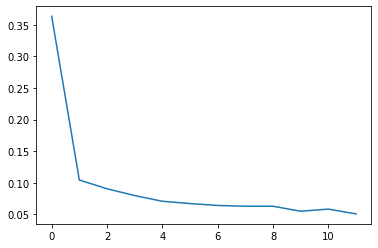

In [19]:
plt.plot(hist.history['loss'])
plt.show()

In [20]:
predicted_stock_price = regressor.predict(X_test)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

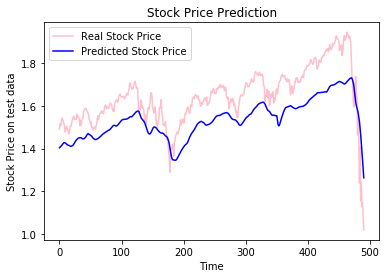

In [21]:
# Visualising the test results
plt.plot(y_test, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price on test data')
plt.legend()
plt.show()

In [22]:
predicted_stock_price = regressor.predict(X_valid)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

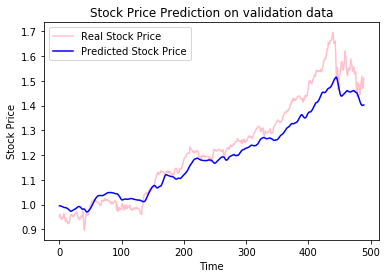

In [23]:
# Visualising the validation results
plt.plot(y_valid, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on validation data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [24]:
# r2_score(y_valid, predicted_stock_price)
SS_res = np.sum(np.square(y_valid - predicted_stock_price))
print('SS_res = ',SS_res)
SS_tot = np.sum(np.square(y_valid - np.mean(y_valid)))
print('SS_tot = ',SS_tot)
SS_reg = np.sum(np.square(predicted_stock_price - np.mean(y_valid)))
print('SS_reg = ',SS_reg)
r2 = 1 - SS_res/SS_tot
print('r2 = ',r2)
r2 = SS_reg/SS_tot
print('r2 = ',r2)
mse = np.mean(np.square(y_valid - predicted_stock_price))
print('mse = ',mse)

SS_res =  16505.8174392499
SS_tot =  20.91393410297218
SS_reg =  12.771409
r2 =  -788.2258509557117
r2 =  0.6106650700842553
mse =  0.06874559533215285


In [25]:
predicted_stock_price = regressor.predict(X_train)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

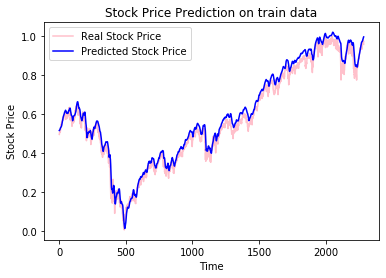

In [26]:
# Visualising the train results
plt.plot(y_train, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on train data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()